<a href="https://colab.research.google.com/github/amishra06/Game-of-Deep-Learning/blob/master/Game_of_Deep_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [0]:
from fastai import *
from fastai.vision import *

In [0]:
#path = Path('gdrive/My Drive/Colab Notebooks/Game of Deep Learning')
path = Path('ships')
dest = path
#dest.mkdir(parents=True, exist_ok=True)
#dest.rmdir()

In [0]:
#!mv *.csv ships/
#!mv images.zip ships/
#!unzip -d ships ships/images.zip

In [0]:
tfms = get_transforms(max_rotate=20, max_zoom=1.3, max_lighting=0.4, max_warp=0.4, p_affine=1., p_lighting=1.)

In [0]:
np.random.seed(42)

#Location of the data -> in 'image' folder of 'path'
#split in train/valid -> randomly with the default 20% in valid
#label ->use the second column of the csv file and split the tags by ','
#Data augmentation -> use tfms with a size of 128
#Finally -> use the defaults for conversion to databunch

data = (ImageList.from_csv(path, 'train.csv', folder='images')
        .split_by_rand_pct()
        .label_from_df(label_delim=',')
        .transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))                          

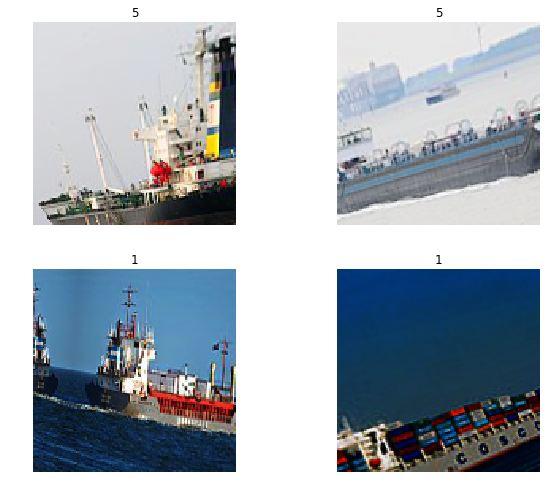

In [7]:
data.show_batch(rows=2, figsize=(9,7))

In [8]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['1', '2', '3', '4', '5'], 5, 5002, 1250)

**Train**

In [0]:
arch = models.resnet50

In [0]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)

In [0]:
learn = cnn_learner(data, arch, metrics=[acc_02, f_score], wd=0.02)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


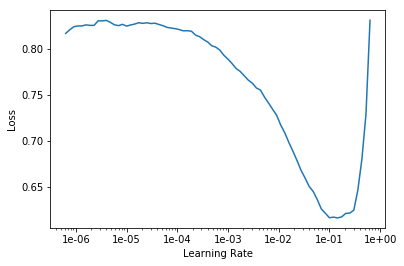

In [12]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr = 0.01

In [14]:
learn.fit_one_cycle(15, slice(lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.515556,0.292161,0.709760,0.770402,00:27
1,0.309882,0.180823,0.893280,0.858457,00:26
2,0.230935,0.158725,0.911840,0.870095,00:26
3,0.188900,0.136302,0.925760,0.890571,00:26
4,0.168369,0.128168,0.933760,0.906305,00:26
5,0.151015,0.111810,0.949120,0.912019,00:26
6,0.139513,0.106012,0.945280,0.923352,00:26
7,0.126214,0.100848,0.949920,0.928552,00:26
8,0.120295,0.093841,0.951360,0.930990,00:26
9,0.109105,0.091344,0.955200,0.934210,00:25


In [0]:
learn.save('stage-1-rn50')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


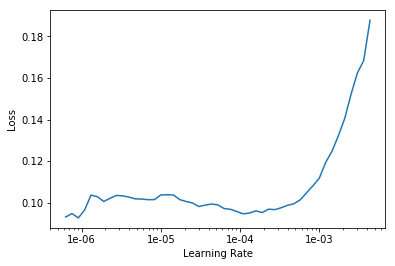

In [17]:
learn.lr_find()
learn.recorder.plot()

In [18]:
learn.fit_one_cycle(15, slice(1e-3/(2.6**4), 1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.096289,0.093016,0.956320,0.932095,00:27
1,0.115054,0.102598,0.951520,0.924819,00:27
2,0.131322,0.120912,0.941440,0.908876,00:27
3,0.127676,0.129678,0.939360,0.904438,00:27
4,0.126171,0.106442,0.954240,0.916210,00:27
5,0.119990,0.100730,0.952480,0.919200,00:27
6,0.113137,0.096951,0.951840,0.923543,00:27
7,0.096567,0.081770,0.965280,0.940114,00:27
8,0.094125,0.093275,0.964640,0.934933,00:27
9,0.075970,0.076463,0.964160,0.943281,00:26


In [0]:
learn.save('stage-2-rn50')

In [0]:
learn.freeze()

In [21]:
data = (ImageList.from_csv(path, 'train.csv', folder='images')
        .split_by_rand_pct()
        .label_from_df(label_delim=',')
        .transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


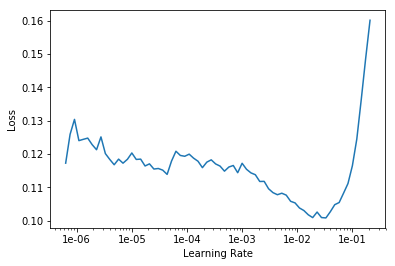

In [22]:
learn.lr_find()
learn.recorder.plot()

In [0]:
lr=4e-3

In [24]:
learn.fit_one_cycle(20, slice(lr), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.105248,0.051986,0.977600,0.965809,01:11
1,0.090062,0.045873,0.978560,0.970476,01:11
2,0.081310,0.042217,0.979200,0.971105,01:11
3,0.076448,0.039367,0.980960,0.974667,01:10
4,0.065888,0.042219,0.980640,0.972000,01:10
5,0.065957,0.033485,0.984320,0.976933,01:11
6,0.058006,0.033066,0.986400,0.977771,01:10
7,0.052065,0.033660,0.986080,0.976533,01:11
8,0.047670,0.032273,0.985600,0.978838,01:10
9,0.052101,0.030954,0.985440,0.978476,01:12


In [0]:
learn.save('stage-1-256-rn50')

In [0]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


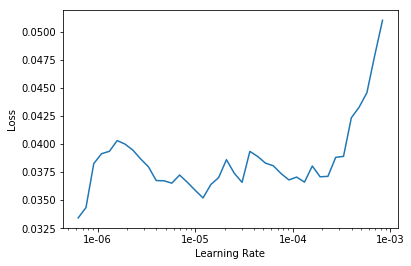

In [27]:
learn.lr_find()
learn.recorder.plot()

In [28]:
learn.fit_one_cycle(20, slice(4e-5/(2.6**4), 4e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.036875,0.030429,0.986880,0.978648,01:15
1,0.039840,0.030632,0.987840,0.979848,01:16
2,0.036878,0.031612,0.986400,0.977600,01:14
3,0.039502,0.033279,0.987840,0.976800,01:16
4,0.037411,0.033404,0.986400,0.976667,01:16
5,0.039533,0.038130,0.984640,0.976133,01:15
6,0.036294,0.039553,0.984000,0.975010,01:16
7,0.035975,0.035265,0.986560,0.978000,01:16
8,0.031448,0.036253,0.987680,0.978933,01:16
9,0.026053,0.037010,0.987520,0.975600,01:16


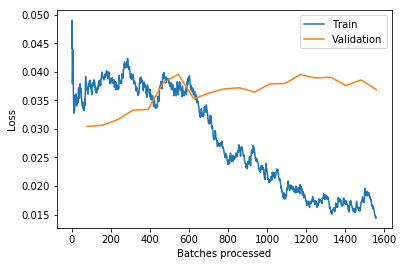

In [29]:
learn.recorder.plot_losses()

In [0]:
learn.save('stage-2-256-rn50')

In [0]:
learn.export()

**Prediction on test set**

In [0]:
test = (ImageList.from_csv(path, 'test.csv', folder='images'))

In [33]:
len(test)

2680

In [0]:
learn = load_learner(path, test=test)

In [0]:
preds, _ = learn.get_preds(ds_type=DatasetType.Test)

In [0]:
#thresh = 0.58
#labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]
labelled_preds = [' '.join([learn.data.classes[i] for i,p in enumerate(pred) if p == max(pred)]) for pred in preds]

In [0]:
#labelled_preds

In [0]:
fnames = [os.path.basename(f) for f in learn.data.test_ds.items]

In [0]:
df = pd.DataFrame({'image':fnames, 'category':labelled_preds}, columns=['image', 'category'])

In [0]:
df.to_csv(path/'submission.csv', index=False)